# Centralized Learning to Federated Learning

COGONI Guillaume (p1810070)

# Import libraries

In [289]:
# Torch
import torch
from torch.utils.data import DataLoader, random_split, Subset
from torch.optim import Adam, lr_scheduler
import torch.nn as nn

# Time
import time

# Random
import random

# Tqdm
from tqdm import tqdm
from tqdm import trange

# Copy
import copy

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

# Pandas
import pandas as pd

# Datetime
from datetime import datetime, timedelta

# Matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [248]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Importation of the dataset

In [249]:
dataset = pd.read_csv("./202207-divvy-tripdata.csv") # Replace by your dataset

In [250]:
data = dataset.copy() # Copy

# Visiualisation

In [251]:
# Print columns, dtypes and the 3 first observation
print(data.columns)
print(data.dtypes)
data.head(3)

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'ride_length', 'day_of_week'],
      dtype='object')
ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
ride_length            object
day_of_week             int64
dtype: object


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week
0,7EA7A3AEAAB5F621,classic_bike,7/1/2022 0:00,7/1/2022 0:11,Sheffield Ave & Wellington Ave,TA1307000052,Sheffield Ave & Waveland Ave,TA1307000126,41.936253,-87.652662,41.949399,-87.654529,casual,0:11:05,6
1,AAB8184C169FF64E,electric_bike,7/1/2022 0:00,7/1/2022 0:41,NaN,NaN,NaN,NaN,41.930000,-87.640000,41.930000,-87.640000,casual,0:41:25,6
2,C60D39A2484F33FB,electric_bike,7/1/2022 0:00,7/1/2022 0:07,Sheffield Ave & Willow St,TA1306000032,Sedgwick St & Schiller St,TA1307000143,41.913730,-87.652776,41.907626,-87.638566,member,0:07:22,6


In [252]:
# Check if there is missing values and how many values are in the dataset
print(data.isna().sum().sort_values(ascending=False))
#print("---------------------------------------------")
#print(data.count().sort_values(ascending=True))

end_station_name      120951
end_station_id        120951
start_station_name    112031
start_station_id      112031
end_lat                  947
end_lng                  947
ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_lat                  0
start_lng                  0
member_casual              0
ride_length                0
day_of_week                0
dtype: int64


# Cleaning the Data

In [253]:
'''
@Param value: a string value with this format "Hour(s):Minute(s):Second(s)" 
'''
def convert_to_seconds(value):
    if not any(char.isdigit() for char in value):
        return pd.NaT
    hour, minute, second = map(int, value.split(':'))
    if hour >= 15:
        hour = 0
    if minute >= 60:
        minute = 0
        hour += 1
    if second >= 60:
        second = 0
        minute += 1
    return hour*3600+minute*60+second

data_prep = data.copy()

# Convert the Series "ride_length" to second
data_prep["ride_length"] = data_prep["ride_length"].apply(convert_to_seconds)

# dropNaN
data_prep = data_prep.dropna()

In [254]:
# Check if there is missing values and how many values are in the dataset
print(data_prep.isna().sum().sort_values(ascending=False))
print("---------------------------------------------")
print(data_prep.count().sort_values(ascending=False))

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
ride_length           0
day_of_week           0
dtype: int64
---------------------------------------------
ride_id               642666
rideable_type         642666
started_at            642666
ended_at              642666
start_station_name    642666
start_station_id      642666
end_station_name      642666
end_station_id        642666
start_lat             642666
start_lng             642666
end_lat               642666
end_lng               642666
member_casual         642666
ride_length           642666
day_of_week           642666
dtype: int64


In [255]:
# Check if ride_length correctly change
data_prep['ride_length'].sort_values(ascending=False)

393742    53998
310446    53971
154978    53960
366777    53854
32965     53619
          ...  
323524        0
199178        0
755309        0
75668         0
185955        0
Name: ride_length, Length: 642666, dtype: object

In [256]:
data_prep['ride_length'] = data_prep['ride_length'].astype('int64')
print(data.shape)
data_prep.dtypes

(823488, 15)


ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
ride_length             int64
day_of_week             int64
dtype: object

# Selection of the features and the target

In [257]:
features = ['start_lat', 
            'start_lng',
            'end_lat',
            'end_lng',
            'member_casual',
            'ride_length',
            'day_of_week',
            'ride_id']
            
target = ["rideable_type"]

In [258]:
data_prep = data_prep.loc[(data_prep["rideable_type"] == "classic_bike") | (data_prep["rideable_type"] == "electric_bike")]
X = data_prep[features]
y = data_prep[target]

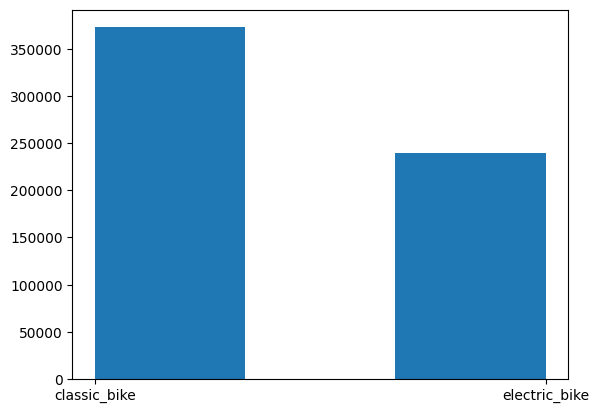

In [259]:
plt.hist(y, bins=3)
plt.show()

In [260]:
print("Information on X (shape and dtype)")
print(X.shape)
print(X.dtypes)
print("\n")
print("Information on y (shape and dtype)")
print(y.shape)
print(y.dtypes)

Information on X (shape and dtype)
(612067, 8)
start_lat        float64
start_lng        float64
end_lat          float64
end_lng          float64
member_casual     object
ride_length        int64
day_of_week        int64
ride_id           object
dtype: object


Information on y (shape and dtype)
(612067, 1)
rideable_type    object
dtype: object


# Preprocessing on the data 

In [261]:
y_OH = OneHotEncoder(handle_unknown='ignore', sparse=False).fit_transform(y)

num_cols = ["start_lat", "start_lng", "end_lat", "end_lng", "day_of_week", "ride_length"]
categorical_cols_less_values = ["member_casual"]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat_less_values', OrdinalEncoder(), categorical_cols_less_values)
    ])

X_prep = preprocessor.fit_transform(X)

c:\Users\gcogoni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Creation of the dataset

In [262]:
X_tensor = torch.tensor(X_prep, dtype=torch.float32)
y_tensor = torch.tensor(y_OH, dtype=torch.float32)

In [263]:
print(X.shape)
print(X_prep.shape)
print(X_tensor.shape)

print(y_OH.shape)
print(y_tensor.shape)

(612067, 8)
(612067, 7)
torch.Size([612067, 7])
(612067, 2)
torch.Size([612067, 2])


In [264]:
dataset_tensor = torch.utils.data.TensorDataset(X_tensor, y_tensor)

In [265]:
len(dataset_tensor)

612067

# Models

In [266]:
class MyNet(nn.Module):
    def __init__(self, _Input, _Output):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(_Input, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, _Output)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Centralized Version

## Separation of the data (train and validation)

In [267]:
train_size = int(0.6 * len(dataset_tensor))
val_size = len(dataset_tensor) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset_tensor, [train_size, val_size])

In [268]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3200, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=3200, shuffle=True)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes= {'train': len(train_dataset), 'val': len(val_dataset)}

# Train and Test function

In [269]:
def train_and_test_nn(model, criterion, optimizer, dataloaders, batch_size, num_epochs=25):

    since = time.time()
    # Instantiate the neural network and the optimizer
    model = model
    optimizer = optimizer
    criterion = criterion
    best_acc_avg = 0.0

    #pbar = trange(num_epochs, unit="carrots")

    # Train the neural network
    for epoch in range(num_epochs):
        print("\n")
        print("_________________________Epoch %d / %d ____________________" % (epoch+1, num_epochs))
        print("\n")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            correct = 0
            precision = 0.0
            recall = 0.0
            i = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item()
                    correct += torch.sum(preds == torch.argmax(labels,1))
                    precision += precision_score(torch.argmax(labels,1), preds)
                    recall += recall_score(torch.argmax(labels,1), preds)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                i+=1
            
            ##Statistics

            # Calculate the average loss
            loss_avg = running_loss / (i+1)

            # Calculate the average accuracy
            accuracy_avg = correct.double() / dataset_sizes[phase]

            # Calculate the average precision and recall
            precision_avg = precision / (i+1)

            # Calculate the average recall
            recall_avg = recall / (i+1)


            # Print the average loss, accuracy, precision, recall for once for train and val per epoch
            print('PHASE %s:  [AVG loss: %.3f || AVG Accuracy: %.4f] [AVG Precision: %.3f || AVG Recall: %.3f]' % 
                  (phase, loss_avg, accuracy_avg, precision_avg, recall_avg))
            

            # deep copy the model
            if phase == 'val' and accuracy_avg > best_acc_avg:
                best_acc_avg = accuracy_avg
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print("\n")
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc_avg))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


# Starting training and validation

In [303]:
model = MyNet(X_tensor.shape[1], y_tensor.shape[1])
epochs = 20
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = Adam(model.parameters(), lr=0.001)

# decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

model_ft = train_and_test_nn(model, criterion, optimizer_ft, dataloaders, 1, num_epochs=10)



_________________________Epoch 1 / 10 ____________________


PHASE train:  [AVG loss: 0.652 || AVG Accuracy: 0.6081] [AVG Precision: 0.524 || AVG Recall: 0.143]
PHASE val:  [AVG loss: 0.639 || AVG Accuracy: 0.6271] [AVG Precision: 0.571 || AVG Recall: 0.167]


_________________________Epoch 2 / 10 ____________________




KeyboardInterrupt: 

# Federated Version

In [373]:
global_model = MyNet(X_tensor.shape[1], y_tensor.shape[1])
local_model = MyNet(X_tensor.shape[1], y_tensor.shape[1])

In [374]:
def params_models_equals(model_1,model_2):
    """_summary_

    Args:
        model_1 (_type_): a neural network pythorch
        model_2 (_type_): a neural network pytorch
    """
    
    # Vérifier si les deux modèles ont les mêmes paramètres
    params_1 = model_1.state_dict()
    params_2 = model_2.state_dict()

    equal = all([torch.allclose(params_1[key], params_2[key]) for key in params_1.keys()])

    if equal:
        print("The models have the same parameters.")
    else:
        print("The models have differents parameters.")

## Creation Nodes

In [386]:
node_1_data, node_2_data, node_3_data, node_4_data, _ = torch.utils.data.random_split(dataset_tensor, [10000, 10000, 10000, 10000, len(dataset_tensor) - 40000])
#node_1_data, node_2_data, _ = torch.utils.data.random_split(dataset_tensor, [300000, 300000, len(dataset_tensor) - 600000])

### Splitting node_i_data into train_data and val_data

In [387]:
nodes = {
        'node_1': {'model': copy.deepcopy(local_model), 'data': node_1_data},
        'node_2': {'model': copy.deepcopy(local_model), 'data': node_2_data},
        'node_3': {'model': copy.deepcopy(local_model), 'data': node_3_data},
        'node_4': {'model': copy.deepcopy(local_model), 'data': node_4_data}
}
""" nodes = {
        'node_1': {'model': copy.deepcopy(local_model), 'data': node_1_data},
        'node_2': {'model': copy.deepcopy(local_model), 'data': node_2_data},

} """

" nodes = {\n        'node_1': {'model': copy.deepcopy(local_model), 'data': node_1_data},\n        'node_2': {'model': copy.deepcopy(local_model), 'data': node_2_data},\n\n} "

In [388]:
def split_data_nodes(nodes):
    """_summary_

    Args:
        nodes (_type_):
        {
            'node_1' :
            {
                model: #, 
                data : #
            },
            'node_2' :
            {
                model: #, 
                data : #
            }, ...
        }

    Returns:
        _type_: a new dictionnary of nodes with a new format 
        {
            'node_1' :
            {
                model: #, 
                data : 
                {
                    train_data: #,
                    val_data: #
                }
            }, ...
        }
    """
    for node in nodes.keys():
        train_data, val_data = torch.utils.data.random_split(nodes[node]['data'], [0.5, 0.5])
        nodes[node]['data'] = {'train_data': train_data, 'val_data': val_data}
    return nodes

In [389]:
nodes = split_data_nodes(nodes)

### Copying global model parameters into local model of nodes

In [390]:
""" for node in nodes.keys():
  params_models_equals(nodes[node]['model'], global_model) """

" for node in nodes.keys():\n  params_models_equals(nodes[node]['model'], global_model) "

In [391]:
def send_global_model_to_node(global_model, node):
        """Send the parameters of the global model to a local model of a node

        Args:
            global_model (_type_): _description_
            node (_type_): {'model': #, 'train_data': #, 'val_data': #}

        Returns:
            _type_: _description_
        """
        node['model'].load_state_dict(copy.deepcopy(global_model.state_dict()))
        return node

In [392]:
""" # We send the main model to the nodes. 
for node in nodes.keys():
    nodes[node] = send_global_model_to_node(global_model, nodes[node]) """

' # We send the main model to the nodes. \nfor node in nodes.keys():\n    nodes[node] = send_global_model_to_node(global_model, nodes[node]) '

In [393]:
""" for node in nodes.keys():
  params_models_equals(nodes[node]['model'], global_model) """

" for node in nodes.keys():\n  params_models_equals(nodes[node]['model'], global_model) "

## Function to Selection nodes that will train the global model

In [394]:
def selection_nodes(nb_nodes, nodes):
    """_summary_

    Args:
        nb_nodes (_type_): _description_
        nodes (_type_): 
        {
            'node_1' :
            {
                model: #, 
                data : #
            },
            'node_2' :
            {
                model: #, 
                data : #
            }, ...
        }

    Returns:
        _type_: a list of node_name that will participate to the training. 
    """
    nb_nodes_names = len(nodes.keys())
    if(nb_nodes > nb_nodes_names) : nb_nodes = nb_nodes_names
    elif(nb_nodes < 1) : nb_nodes = 1
    return random.sample(list(nodes.keys()), nb_nodes)

## Training node

In [395]:
def train_and_test_node(node, criterion, optimizer, batch_size_train, batch_size_test, num_epochs=25):
    """_summary_

    Args:
        node (_type_): _description_
        criterion (_type_): _description_
        optimizer (_type_): _description_
        batch_size_train (_type_): _description_
        batch_size_test (_type_): _description_
        num_epochs (int, optional): _description_. Defaults to 25.

    Returns:
        _type_: _description_
    """
    train_loader = torch.utils.data.DataLoader(node['data']['train_data'], batch_size=batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(node['data']['val_data'], batch_size=batch_size_test, shuffle=True)

    dataloaders = {'train': train_loader, 'val': val_loader}
    dataset_sizes= {'train': len(node['data']['train_data']), 'val': len(node['data']['train_data'])}

    since = time.time()
    # Instantiate the neural network and the optimizer
    model = node['model']
    optimizer = optimizer
    criterion = criterion
    best_acc_avg = 0.0

    #pbar = trange(num_epochs, unit="carrots")

    # Train the neural network
    for epoch in range(num_epochs):
        """ print("\n")
        print("_________________________Epoch %d / %d ____________________" % (epoch+1, num_epochs))
        print("\n") """
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            correct = 0
            precision = 0.0
            recall = 0.0
            i = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item()
                    correct += torch.sum(preds == torch.argmax(labels,1))
                    precision += precision_score(torch.argmax(labels,1), preds)
                    recall += recall_score(torch.argmax(labels,1), preds)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                i+=1
            
            ##Statistics

            # Calculate the average loss
            loss_avg = running_loss / (i+1)

            # Calculate the average accuracy
            accuracy_avg = correct.double() / dataset_sizes[phase]

            # Calculate the average precision and recall
            precision_avg = precision / (i+1)

            # Calculate the average recall
            recall_avg = recall / (i+1)


            # Print the average loss, accuracy, precision, recall for once for train and val per epoch
            """ print('PHASE %s:  [AVG loss: %.3f || AVG Accuracy: %.4f] [AVG Precision: %.3f || AVG Recall: %.3f]' % 
                (phase, loss_avg, accuracy_avg, precision_avg, recall_avg)) """
            

            # deep copy the model
            if phase == 'val' and accuracy_avg > best_acc_avg:
                best_acc_avg = accuracy_avg
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    """ print("\n")
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc_avg)) """

    # load best model weights
    model.load_state_dict(best_model_wts)
    return {'model': model, 'node_best_acc_avg': best_acc_avg}


In [396]:
""" nodes_best_avg = {}

for node in nodes:
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(nodes[node]['model'].parameters(), lr=0.001)
    model_best_acc_avg = train_and_test_node(nodes[node], criterion, optimizer, 5000, 5000, num_epochs=10)
    nodes[node]['model'] = model_best_acc_avg['model']
    nodes_best_avg[node] = model_best_acc_avg['node_best_acc_avg']
print(nodes_best_avg) """

" nodes_best_avg = {}\n\nfor node in nodes:\n    criterion = nn.CrossEntropyLoss()\n    optimizer = Adam(nodes[node]['model'].parameters(), lr=0.001)\n    model_best_acc_avg = train_and_test_node(nodes[node], criterion, optimizer, 5000, 5000, num_epochs=10)\n    nodes[node]['model'] = model_best_acc_avg['model']\n    nodes_best_avg[node] = model_best_acc_avg['node_best_acc_avg']\nprint(nodes_best_avg) "

In [397]:
""" def send_local_model_for_agg(global_model, nodes, node_in_training_mode):
    temp = node_in_training_mode.copy()
    state_dict = nodes[temp.pop(0)]['model'].state_dict()
    for node in node_in_training_mode:
        for name, param in nodes[node]["model"].named_parameters():            
            state_dict[name] = state_dict[name] + nodes[node]["model"].state_dict()[name]
        state_dict[name] = state_dict[name]/(len(node_in_training_mode)+1)
        global_model.load_state_dict(state_dict)
    return global_model """

' def send_local_model_for_agg(global_model, nodes, node_in_training_mode):\n    temp = node_in_training_mode.copy()\n    state_dict = nodes[temp.pop(0)][\'model\'].state_dict()\n    for node in node_in_training_mode:\n        for name, param in nodes[node]["model"].named_parameters():            \n            state_dict[name] = state_dict[name] + nodes[node]["model"].state_dict()[name]\n        state_dict[name] = state_dict[name]/(len(node_in_training_mode)+1)\n        global_model.load_state_dict(state_dict)\n    return global_model '

In [398]:
""" node_selectioned = selection_nodes(3, nodes)
global_model = send_local_model_for_agg(global_model, nodes, node_in_training_mode) """

' node_selectioned = selection_nodes(3, nodes)\nglobal_model = send_local_model_for_agg(global_model, nodes, node_in_training_mode) '

In [403]:
def plan_training_global_model(nodes, global_model, nb_round, nb_epoch, nb_nodes_selectioned):
    nodes_selectioned = selection_nodes(nb_nodes_selectioned, nodes)
    nodes_best_avg = {}
    # We send the main model to the selectioned nodes. 
    for node in nodes_selectioned:
        nodes[node] = send_global_model_to_node(global_model, nodes[node])
    print(node_selectioned)
    for k in range(nb_round):
        nodes_best_avg[k] = {} 
        print("\n")
        print("############################################################")
        print("_________________________Round %d / %d ____________________" % (k+1, nb_round))
        print("############################################################")
        print("\n")
        for node in nodes_selectioned:
            criterion = nn.CrossEntropyLoss()
            optimizer = Adam(nodes[node]['model'].parameters(), lr=0.001)
            model_best_acc_avg = train_and_test_node(nodes[node], criterion, optimizer, 100, 100, num_epochs=nb_epoch)
            nodes[node]['model'] = model_best_acc_avg['model']
            nodes_best_avg[k][node] = model_best_acc_avg['node_best_acc_avg']
        for node in nodes_selectioned:
            params_models_equals(nodes[node]['model'], global_model)
        global_model = send_local_model_for_agg(global_model, nodes, nodes_selectioned)
        for node in nodes_selectioned:
            send_global_model_to_node(global_model, nodes[node])
        for node in nodes_selectioned:
            params_models_equals(nodes[node]['model'], global_model)
    print(nodes_best_avg)

In [404]:
plan_training_global_model(nodes,global_model, 4, 20, 4)

['node_1', 'node_3', 'node_4']


############################################################
_________________________Round 1 / 4 ____________________
############################################################


The models have differents parameters.
The models have differents parameters.
The models have differents parameters.
The models have differents parameters.
The models have the same parameters.
The models have the same parameters.
The models have the same parameters.
The models have the same parameters.


############################################################
_________________________Round 2 / 4 ____________________
############################################################


The models have differents parameters.
The models have differents parameters.
The models have differents parameters.
The models have differents parameters.
The models have the same parameters.
The models have the same parameters.
The models have the same parameters.
The models have the same param